<a href="https://colab.research.google.com/github/R-Madhuram/UC-BerkeleyCapstone_CreditCardFraudDetection/blob/main/notebooks/3_ensemble_methods/10_Stacking_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stacking Classifier

In [ ]:
# Import the libraries
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [ ]:
!pip install catboost 
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.0 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc,RocCurveDisplay,PrecisionRecallDisplay

In [ ]:
import pandas as pd
import numpy as np
import pickle

In [ ]:
from sklearn import preprocessing
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.model_selection import cross_validate

## Importing helper functions



In [ ]:
# Import the helper functions
# Import the required functions from the helper function file
from helper_functions_ml import createMetricsDF,computeModelMetrics,computeAndPlotMetrics

## Import the Data (training and testing)

In [ ]:
# Read the training data
df_train = pd.read_csv('df.csv')
print(df_train.head())

df_train = df_train.drop('Unnamed: 0', axis=1)
df_train.head(3)
print(df_train.shape)

   Unnamed: 0  TransactionID  isFraud  TransactionDT  TransactionAmt  \
0           0        2987000        0          86400        1.835691   
1           1        2987001        0          86401        1.462398   
2           2        2987002        0          86469        1.770852   
3           3        2987003        0          86499        1.698970   
4           4        2987004        0          86506        1.698970   

   ProductCD  card1  card2  card3  card4  ...  id_36  id_37  id_38  \
0          4  13926   -1.0  150.0      1  ...      2      2      2   
1          4   2755  404.0  150.0      2  ...      2      2      2   
2          4   4663  490.0  150.0      4  ...      2      2      2   
3          4  18132  567.0  150.0      2  ...      2      2      2   
4          1   4497  514.0  150.0      2  ...      0      1      1   

   DeviceType  DeviceInfo  P_emaildomain_addr1_card1  card1_card2  \
0           1        1735                      63363         3655   
1       

In [ ]:
# CP cannot be used to copy file here because numFolds is a variable and hence the filenames will change based on the number of folds.
# instead of using linux CP command we use SHUTIL copy 

# read the K fold train and dev indices

numFolds = 3

import shutil # file copy package. 

srcFileName = 'Classification_Products\train_dev_indices_' + str(numFolds) + '.pickle' 
train_dev_indices_file = 'train_dev_indices_' + str(numFolds) + '.pickle'
# !cp  srcFileName destFileName
shutil.copyfile(srcFileName, train_dev_indices_file)


'train_dev_indices_3.pickle'

In [ ]:
# read the train dev indices file
# train_dev_indices_df = pd.read_csv(train_dev_indices_file)
# train_dev_indices_df.head()

with open(train_dev_indices_file, 'rb') as handle:
    train_dev_indices = pickle.load(handle)
train_dev_indices

{'train': [array([195756, 195757, 195758, ..., 590537, 590538, 590539]),
  array([     0,      1,      2, ..., 590537, 590538, 590539]),
  array([     0,      1,      2, ..., 397410, 397417, 397418])],
 'dev': [array([     0,      1,      2, ..., 221151, 221172, 221182]),
  array([195756, 195757, 195758, ..., 397410, 397417, 397418]),
  array([393481, 393482, 393483, ..., 590537, 590538, 590539])]}

In [ ]:
# Getting dataready
X = df_train.drop(columns = ['isFraud','TransactionID'])
y = df_train['isFraud']

In [ ]:
# List of categorical and numerical columns in merged dataset

## Numerical columns

num_column_lst_final = []
for icol in X.columns:
  if X[icol].dtypes in ['float64', 'int64']:
    num_column_lst_final.append(icol)
print(f"The columns that have numerical features are: '{num_column_lst_final}'")
print(f"The number of columns that have numerical features are: '{len(num_column_lst_final)}'")

print('\n')

## Categorical Columns
cat_column_lst_final = []
for icol in X.columns:
  if X[icol].dtypes in ['object']:
    cat_column_lst_final.append(icol)
print(f"The columns that have categorical features are: '{cat_column_lst_final}'")
print(f"The number of columns that have categorical features are: '{len(cat_column_lst_final)}'")


The columns that have numerical features are: '['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C3', 'C5', 'D1', 'D3', 'D4', 'D8', 'D9', 'D10', 'D13', 'D14', 'M1', 'M2', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V4', 'V6', 'V10', 'V12', 'V14', 'V15', 'V19', 'V23', 'V25', 'V27', 'V35', 'V37', 'V39', 'V44', 'V46', 'V53', 'V55', 'V61', 'V66', 'V75', 'V77', 'V82', 'V86', 'V95', 'V98', 'V99', 'V104', 'V107', 'V108', 'V109', 'V117', 'V118', 'V120', 'V121', 'V123', 'V124', 'V129', 'V135', 'V138', 'V139', 'V141', 'V144', 'V148', 'V161', 'V169', 'V170', 'V172', 'V173', 'V174', 'V184', 'V194', 'V208', 'V209', 'V214', 'V220', 'V221', 'V223', 'V224', 'V226', 'V227', 'V228', 'V238', 'V240', 'V241', 'V250', 'V260', 'V270', 'V281', 'V282', 'V284', 'V286', 'V288', 'V290', 'V300', 'V305', 'V313', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',

## Ensemble Models

###  1. HistGradient Boosting (inspired from LightGBM)


In [ ]:
numFolds = 3

In [ ]:
# loop through each fold, retrieve the train and dev ids for each fold before running the basic logisitic regression model on each fold
## model 4
y_pred4_tunedHistGB_train = {}
y_pred4_tunedHistGB_dev = {}

y_pred4_tunedHistGB_train_prob = {}
y_pred4_tunedHistGB_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe_clf_hist = Pipeline([('preprocessor', preprocessor), 
                   ('clf_hist', HistGradientBoostingClassifier(l2_regularization=1.0, 
                                                              class_weight ='balanced',
                                                              max_bins= 10, 
                                                              max_depth=150, 
                                                              validation_fraction=0.18, 
                                                              max_iter=300, 
                                                              min_samples_leaf=120, 
                                                              max_leaf_nodes=100,
                                                              random_state=42))
                   ])
  
  pipe_clf_hist.fit(X_train,y_train)

  y_pred4_tunedHistGB_train[i_fold] = pipe_clf_hist.predict(X_train)
  y_pred4_tunedHistGB_dev[i_fold] = pipe_clf_hist.predict(X_dev)

  y_pred4_tunedHistGB_train_prob[i_fold] = pipe_clf_hist.predict_proba(X_train)[:,1]
  y_pred4_tunedHistGB_dev_prob[i_fold] = pipe_clf_hist.predict_proba(X_dev)[:,1]

### CatBoost Classifier

In [ ]:
y_pred4_cat_train = {}
y_pred4_cat_dev = {}

y_pred4_cat_train_prob = {}
y_pred4_cat_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe_clf_catb = Pipeline([('preprocessor', preprocessor), ('clf_cat', CatBoostClassifier(task_type="GPU", 
                                                                                          devices='0:1',
                                                                                          num_boost_round=300,
                                                                                          learning_rate=0.01,grow_policy='Depthwise',
                                                                                          scale_pos_weight=10, 
                                                                                          depth=15, 
                                                                                          score_function='L2', 
                                                                                          eval_metric='AUC', 
                                                                                          bootstrap_type='Poisson',
                                                                                          subsample=0.8,
                                                                                          random_seed=42))])
  
                                                                                  
  pipe_clf_catb.fit(X_train,y_train)

  y_pred4_cat_train[i_fold] = pipe_clf_catb.predict(X_train)
  y_pred4_cat_dev[i_fold] = pipe_clf_catb.predict(X_dev)

  y_pred4_cat_train_prob[i_fold] = pipe_clf_catb.predict_proba(X_train)[:,1]
  y_pred4_cat_dev_prob[i_fold] = pipe_clf_catb.predict_proba(X_dev)[:,1]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 189ms	remaining: 56.6s
1:	total: 371ms	remaining: 55.3s
2:	total: 519ms	remaining: 51.4s
3:	total: 620ms	remaining: 45.9s
4:	total: 730ms	remaining: 43s
5:	total: 845ms	remaining: 41.4s
6:	total: 956ms	remaining: 40s
7:	total: 1.06s	remaining: 38.7s
8:	total: 1.17s	remaining: 37.9s
9:	total: 1.29s	remaining: 37.5s
10:	total: 1.43s	remaining: 37.6s
11:	total: 1.56s	remaining: 37.5s
12:	total: 1.67s	remaining: 36.8s
13:	total: 1.79s	remaining: 36.7s
14:	total: 1.92s	remaining: 36.5s
15:	total: 2.04s	remaining: 36.2s
16:	total: 2.16s	remaining: 36s
17:	total: 2.25s	remaining: 35.3s
18:	total: 2.4s	remaining: 35.5s
19:	total: 2.53s	remaining: 35.4s
20:	total: 2.65s	remaining: 35.3s
21:	total: 2.76s	remaining: 34.9s
22:	total: 2.89s	remaining: 34.8s
23:	total: 3.01s	remaining: 34.6s
24:	total: 3.13s	remaining: 34.4s
25:	total: 3.23s	remaining: 34s
26:	total: 3.34s	remaining: 33.8s
27:	total: 3.48s	remaining: 33.8s
28:	total: 3.59s	remaining: 33.6s
29:	total: 3.72s	remaining: 33.5s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 222ms	remaining: 1m 6s
1:	total: 413ms	remaining: 1m 1s
2:	total: 629ms	remaining: 1m 2s
3:	total: 857ms	remaining: 1m 3s
4:	total: 1.11s	remaining: 1m 5s
5:	total: 1.37s	remaining: 1m 7s
6:	total: 1.65s	remaining: 1m 8s
7:	total: 1.92s	remaining: 1m 10s
8:	total: 2.17s	remaining: 1m 10s
9:	total: 2.43s	remaining: 1m 10s
10:	total: 2.71s	remaining: 1m 11s
11:	total: 2.96s	remaining: 1m 11s
12:	total: 3.25s	remaining: 1m 11s
13:	total: 3.55s	remaining: 1m 12s
14:	total: 3.81s	remaining: 1m 12s
15:	total: 4.09s	remaining: 1m 12s
16:	total: 4.37s	remaining: 1m 12s
17:	total: 4.63s	remaining: 1m 12s
18:	total: 4.77s	remaining: 1m 10s
19:	total: 4.88s	remaining: 1m 8s
20:	total: 5.01s	remaining: 1m 6s
21:	total: 5.14s	remaining: 1m 4s
22:	total: 5.27s	remaining: 1m 3s
23:	total: 5.4s	remaining: 1m 2s
24:	total: 5.51s	remaining: 1m
25:	total: 5.64s	remaining: 59.5s
26:	total: 5.76s	remaining: 58.3s
27:	total: 5.89s	remaining: 57.3s
28:	total: 6.04s	remaining: 56.5s
29:	total: 6.19s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 219ms	remaining: 1m 5s
1:	total: 368ms	remaining: 54.8s
2:	total: 499ms	remaining: 49.4s
3:	total: 605ms	remaining: 44.8s
4:	total: 718ms	remaining: 42.4s
5:	total: 833ms	remaining: 40.8s
6:	total: 958ms	remaining: 40.1s
7:	total: 1.06s	remaining: 38.9s
8:	total: 1.18s	remaining: 38.2s
9:	total: 1.31s	remaining: 38.1s
10:	total: 1.43s	remaining: 37.6s
11:	total: 1.55s	remaining: 37.2s
12:	total: 1.66s	remaining: 36.6s
13:	total: 1.77s	remaining: 36.3s
14:	total: 1.9s	remaining: 36s
15:	total: 2.02s	remaining: 35.8s
16:	total: 2.14s	remaining: 35.6s
17:	total: 2.27s	remaining: 35.6s
18:	total: 2.39s	remaining: 35.4s
19:	total: 2.51s	remaining: 35.2s
20:	total: 2.63s	remaining: 34.9s
21:	total: 2.75s	remaining: 34.7s
22:	total: 2.87s	remaining: 34.6s
23:	total: 2.99s	remaining: 34.4s
24:	total: 3.11s	remaining: 34.3s
25:	total: 3.23s	remaining: 34s
26:	total: 3.37s	remaining: 34.1s
27:	total: 3.49s	remaining: 33.9s
28:	total: 3.62s	remaining: 33.8s
29:	total: 3.73s	remaining: 3

### XGB Classifier

In [ ]:
!pip install --upgrade imbalanced-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 KB 12.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
# SMOTE Sampling for the imbalanced dataset
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
from sklearn.model_selection import StratifiedKFold
numFolds = 3
skf = StratifiedKFold(n_splits=numFolds)

In [ ]:
from math import sqrt

y_pred4_xgb_train = {}  
y_pred4_xgb_dev = {}

y_pred4_xgb_train_prob = {}
y_pred4_xgb_dev_prob = {}

y_train_folds_smote = {}
y_dev_folds_smote ={}

i_fold=0

for train, dev in skf.split(X_smote, y_smote):
  X_train = X_smote.loc[train,:]
  X_dev = X_smote.loc[dev,:]

  y_train = y_smote[train]
  y_dev = y_smote[dev]

  y_train_folds_smote[i_fold] = y_train
  y_dev_folds_smote[i_fold] = y_dev

  scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))

  preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), num_column_lst_final)],
                      remainder='passthrough'
                      )
  pipe_clf_xgb = Pipeline([('preprocessor', preprocessor), 
                   ('clf_xgb', XGBClassifier( max_depth=7,
                                            #subsample=0.8,
                                            num_round=100,
                                            eta=0.8,
                                            gamma=4,
                                            min_child_weight=6,
                                            silent=0,
                                            objective='binary:logistic',
                                            eval_metric='auc',
                                            tree_method = 'gpu_hist',
                                            reg_lambda = 4,
                                            num_parallel_tree = 10,
                                            scale_pos_weight= scale_pos_weight,
                                            seed=42))
                 ])
  pipe_clf_xgb.fit(X_train,y_train)

  y_pred4_xgb_train[i_fold] = pipe_clf_xgb.predict(X_train)
  y_pred4_xgb_dev[i_fold] = pipe_clf_xgb.predict(X_dev)

  y_pred4_xgb_train_prob[i_fold] = pipe_clf_xgb.predict_proba(X_train)[:,1]
  y_pred4_xgb_dev_prob[i_fold] = pipe_clf_xgb.predict_proba(X_dev)[:,1]

  i_fold+=1


[04:13:18] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round", "silent" } are not used.

[04:14:31] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round", "silent" } are not used.

[04:15:53] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round", "silent" } are not used.



### Stacking Classifier 1

In [ ]:
y_pred_sc1_train = {}
y_pred_sc1_dev = {}

y_pred_sc1_train_prob = {}
y_pred_sc1_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]

  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  estimators = [
      ("HistGradient booster", pipe_clf_hist),
      ("CatBoost", pipe_clf_catb),
      ("XGB Boosting", pipe_clf_xgb),
              ]

  sc1 = StackingClassifier(estimators = estimators,
                                         cv = 'prefit', 
                                         final_estimator = DecisionTreeClassifier(random_state=42, 
                                                                      class_weight= 'balanced',
                                                                      ccp_alpha=0.05,
                                                                      max_depth = 7,
                                                                      random_state=42),
                                         passthrough = True)
  sc1.fit(X_train,y_train)

  y_pred_sc1_train[i_fold] = sc1.predict(X_train)
  y_pred_sc1_dev[i_fold] = sc1.predict(X_dev)

  y_pred_sc1_train_prob[i_fold] = sc1.predict_proba(X_train)[:,1]
  y_pred_sc1_dev_prob[i_fold] = sc1.predict_proba(X_dev)[:,1]

### Stacking Classifier 2 

In [ ]:
y_pred_sc2_train = {}
y_pred_sc2_dev = {}

y_pred_sc2_train_prob = {}
y_pred_sc2_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]

  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  estimators = [
      ("HistGradient booster", pipe_clf_hist),
      ("CatBoost", pipe_clf_catb),
      ("XGB Boosting", pipe_clf_xgb),
              ]

  sc2 = StackingClassifier(estimators = estimators,
                                         cv = 'prefit', 
                                         final_estimator = RandomForestClassifier(ccp_alpha = 0.001,
                                                                            class_weight='balanced', 
                                                                            random_state=42,
                                                                            max_depth = 12,
                                                                            n_estimators = 1500
                                                                            ),
                                         passthrough = True)
  sc2.fit(X_train,y_train)

  y_pred_sc2_train[i_fold] = sc2.predict(X_train)
  y_pred_sc2_dev[i_fold] = sc2.predict(X_dev)

  y_pred_sc2_train_prob[i_fold] = sc2.predict_proba(X_train)[:,1]
  y_pred_sc2_dev_prob[i_fold] = sc2.predict_proba(X_dev)[:,1]

### Stacking Classifier 3 

In [ ]:
y_pred_sc3_train = {}
y_pred_sc3_dev = {}

y_pred_sc3_train_prob = {}
y_pred_sc3_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]

  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  estimators = [
      ("HistGradient booster", pipe_clf_hist),
      ("CatBoost", pipe_clf_catb),
      ("XGB Boosting", pipe_clf_xgb),
              ]

  sc3 = StackingClassifier(estimators = estimators,
                          cv = 'prefit', 
                          final_estimator = AdaBoostClassifier(learning_rate = 10,
                                                             base_estimator= DecisionTreeClassifier(class_weight='balanced', 
                                                                                                  random_state=42, 
                                                                                                  max_depth = 7, 
                                                                                                  ccp_alpha=0.003)),
                           passthrough = True) 
                                                                            
                                                                           
                                                            
                                                                            
                          
  sc3.fit(X_train,y_train)

  y_pred_sc3_train[i_fold] = sc3.predict(X_train)
  y_pred_sc3_dev[i_fold] = sc3.predict(X_dev)

  y_pred_sc3_train_prob[i_fold] = sc3.predict_proba(X_train)[:,1]
  y_pred_sc3_dev_prob[i_fold] = sc3.predict_proba(X_dev)[:,1]

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


## Evaluation of the model(s)

In [ ]:
thresholds = np.arange(0, 1, .05) 

###  1. HistGradient Boosting (inspired from LightGBM)


KeyError: ignored

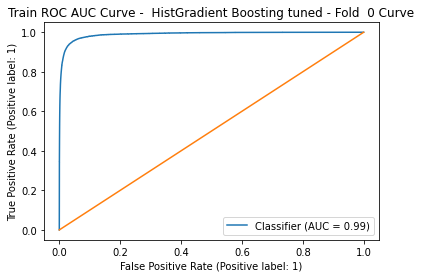

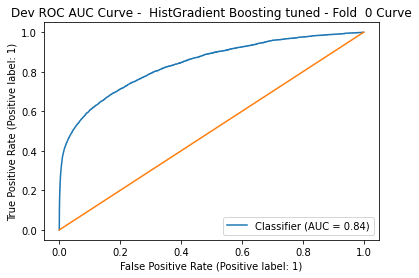

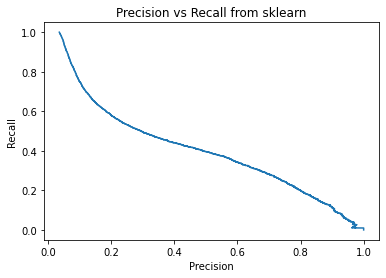

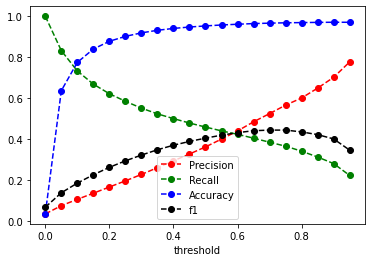

In [ ]:
tunedhistGB4_metrics_DF = []
for i_fold in range(0,numFolds): 
 tunedhistGB4_metrics_DF.append(computeAndPlotMetrics(y_pred4_tunedHistGB_train[i_fold], y_pred4_tunedHistGB_train_prob[i_fold],
                              y_pred4_tunedHistGB_dev[i_fold],y_pred4_tunedHistGB_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'HistGradient Boosting tuned - Fold  ' + str(i_fold) ))

### CatBoost Classifier

In [ ]:
catb4_metrics_DF = []
for i_fold in range(0,numFolds): 
 catb4_metrics_DF.append(computeAndPlotMetrics(y_pred4_cat_train[i_fold],y_pred4_cat_train_prob[i_fold],
                              y_pred4_cat_dev[i_fold],y_pred4_cat_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'CatGradient Boosting4 - Fold  ' + str(i_fold) ))

### XGB Classifier

In [ ]:
xgb4_metrics_DF = []
for i_fold in range(0,numFolds): 
 xgb4_metrics_DF.append(computeAndPlotMetrics(y_pred4_xgb_train[i_fold],y_pred4_xgb_train_prob[i_fold],
                              y_pred4_xgb_dev[i_fold],y_pred4_xgb_dev_prob[i_fold],
                                  y_dev_folds_smote[i_fold],y_train_folds_smote[i_fold],thresholds,
                                  'XG Boosting - Fold  ' + str(i_fold) ))


### Stacking Classfier 1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


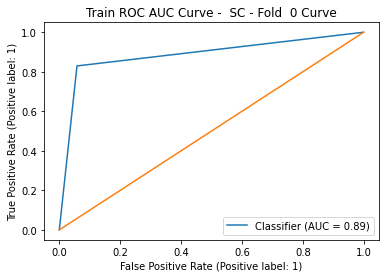

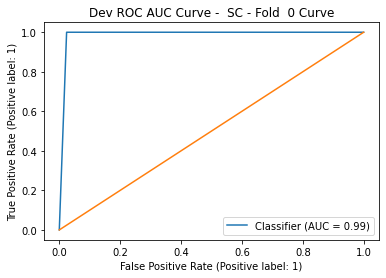

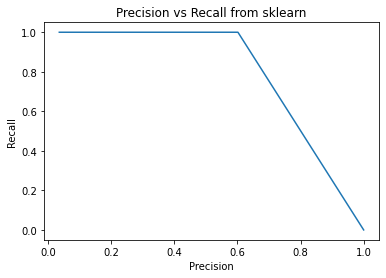

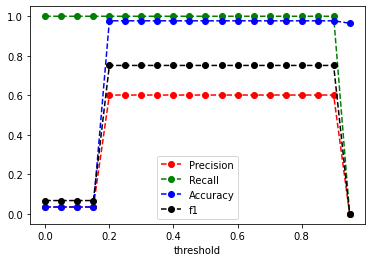

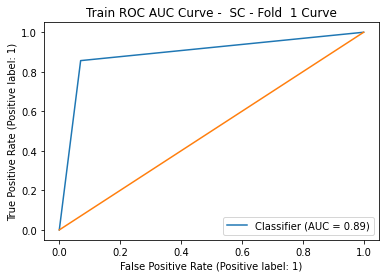

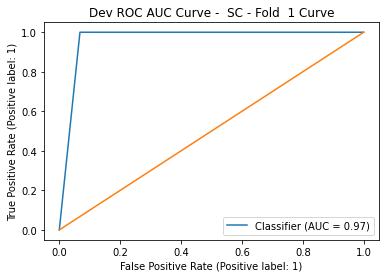

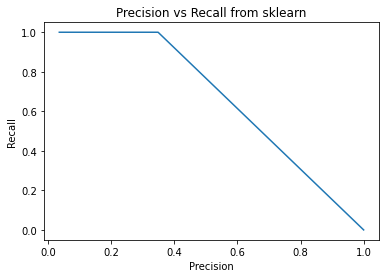

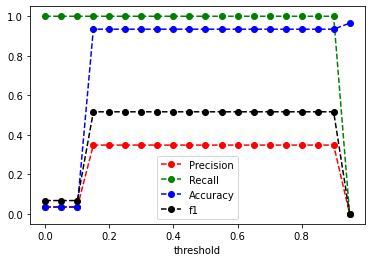

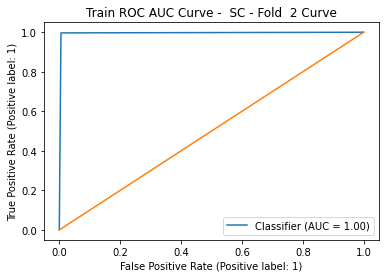

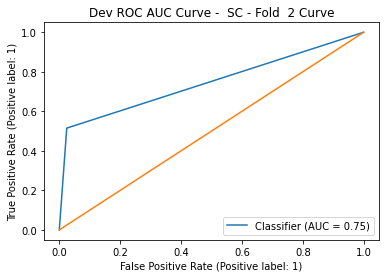

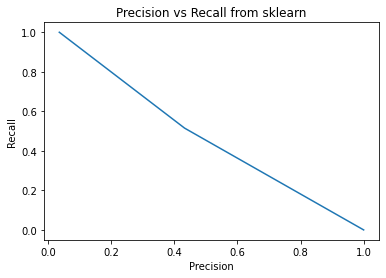

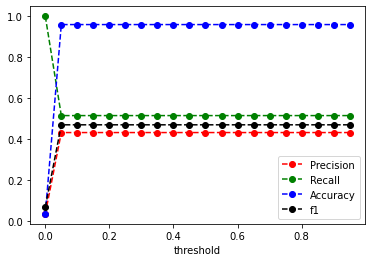

In [ ]:
sc1_metrics_DF = []
for i_fold in range(0,numFolds): 
 sc1_metrics_DF.append(computeAndPlotMetrics(y_pred_sc1_train[i_fold],y_pred_sc1_train_prob[i_fold],
                              y_pred_sc1_dev[i_fold],y_pred_sc1_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'SC - Fold  ' + str(i_fold) ))


### Stacking Classifier 2

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


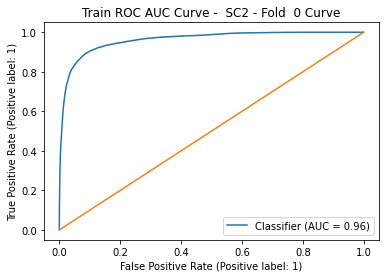

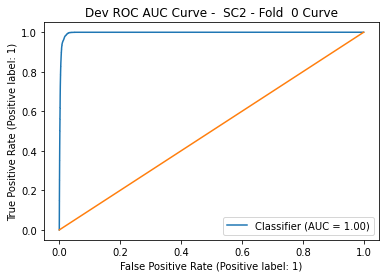

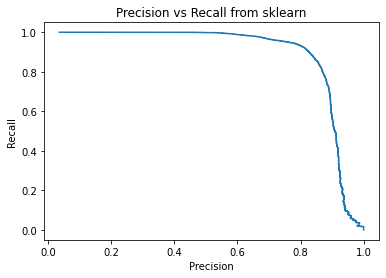

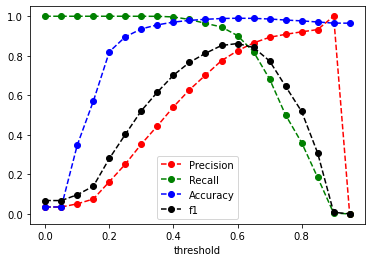

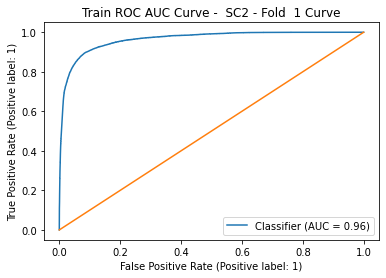

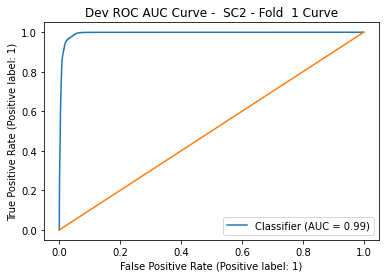

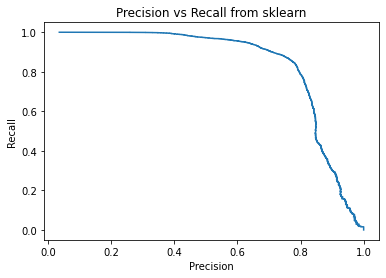

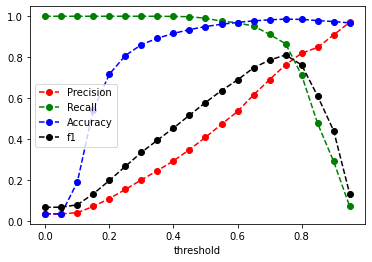

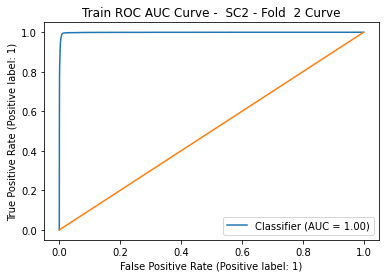

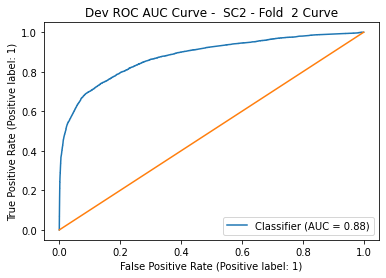

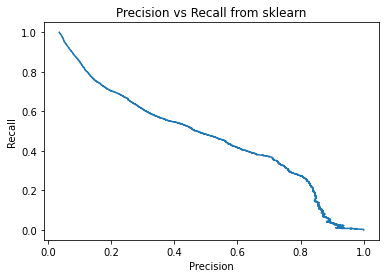

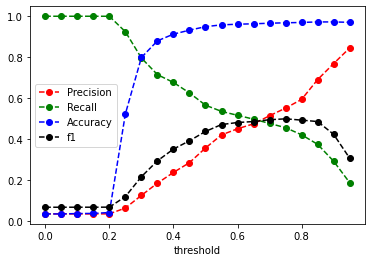

In [ ]:
sc2_metrics_DF = []
for i_fold in range(0,numFolds): 
 sc2_metrics_DF.append(computeAndPlotMetrics(y_pred_sc2_train[i_fold],y_pred_sc2_train_prob[i_fold],
                              y_pred_sc2_dev[i_fold],y_pred_sc2_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'SC2 - Fold  ' + str(i_fold) ))


### Stacking Classifier 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined a

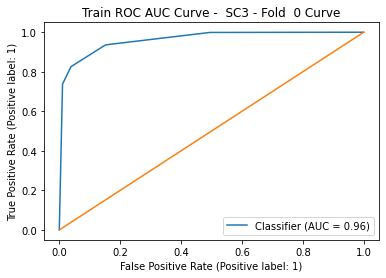

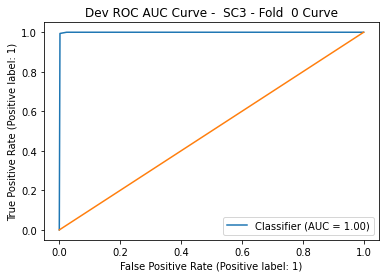

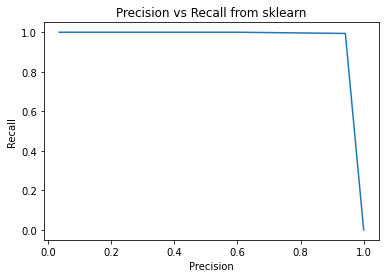

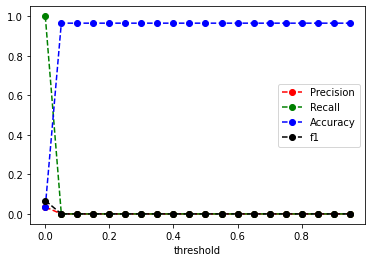

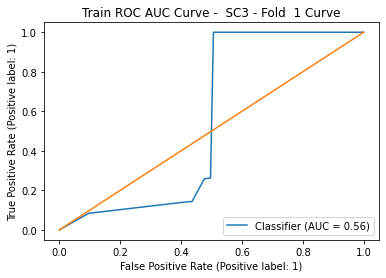

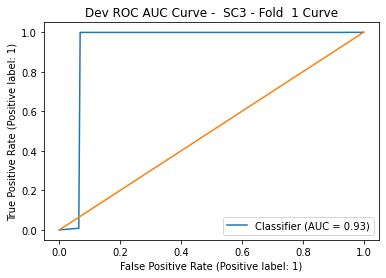

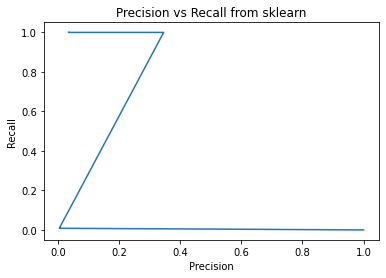

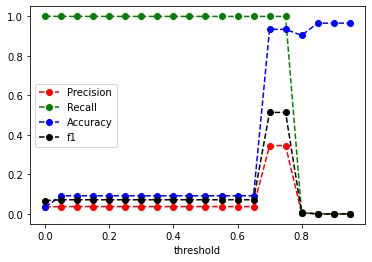

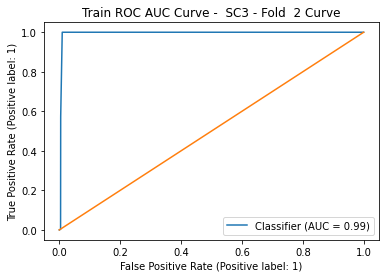

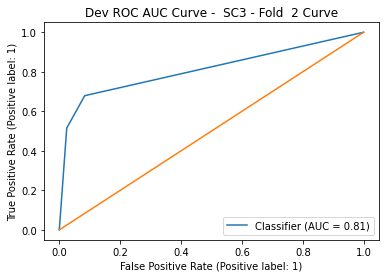

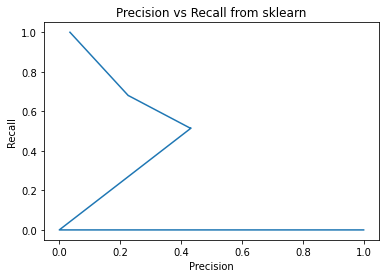

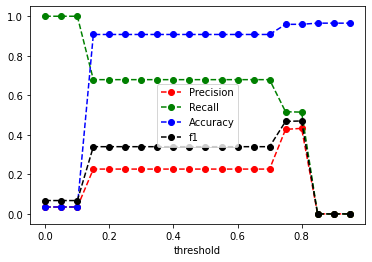

In [ ]:
sc3_metrics_DF = []
for i_fold in range(0,numFolds): 
 sc3_metrics_DF.append(computeAndPlotMetrics(y_pred_sc3_train[i_fold],y_pred_sc3_train_prob[i_fold],
                              y_pred_sc3_dev[i_fold],y_pred_sc3_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'SC3 - Fold  ' + str(i_fold) ))


# Summary

In [ ]:
sc1_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.937936  0.483316   0.340982  0.829619       0.885741
 1  development  0.976809  0.751104   0.601414  1.000000       0.987984,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.927286  0.451832   0.306856  0.856479       0.893166
 1  development  0.934508  0.516574   0.348231  1.000000       0.966066,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.994605  0.928209   0.868501  0.996733       0.995631
 1  development  0.959359  0.469988   0.432192  0.515028       0.745248]

In [ ]:
sc2_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.928381  0.459080   0.311987  0.868603       0.961466
 1  development  0.984435  0.812554   0.702157  0.964141       0.996843,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training   0.92487  0.451039   0.302980  0.882105       0.964484
 1  development   0.94958  0.578860   0.408957  0.990273       0.994196,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.990848  0.883455   0.796779  0.991289       0.998843
 1  development  0.949118  0.437619   0.356770  0.565849       0.879813]

In [ ]:
sc3_metrics_DF

[  Dataset Type  accuracy  f1 score  precision  recall  roc auc score
 0     training  0.102328  0.072318   0.037515     1.0       0.962368
 1  development  0.965008  0.000000   0.000000     0.0       0.998816,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.070855  0.070040   0.036291  1.000000       0.555930
 1  development  0.091726  0.071481   0.037066  0.999129       0.933194,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.961412  0.644582   0.475559  1.000000       0.994443
 1  development  0.907781  0.340107   0.226845  0.679251       0.810992]

From the ensemble models constructed using stacking classifiers and hyperparameter-tuned ensemble methods, we observed that the meta classifier, random forest, employed with stacked ensemble models (LightGBM, CatBoost, and XGBoost), achieved the highest ROC-AUC score of approximately 0.94.

However, it's worth noting that one of our ensemble models (Xtreme Gradient Boosting) utilized SMOTE sampling in both the training and development sets. Additionally, these models pose challenges for hyperparameter tuning due to the numerous parameters involved and the inherent class imbalance.

To further explore the potential of stacking ensemble methods to yield high ROC-AUC scores, we plan to test Auto-ML techniques in ensembling and stacking models. This experimentation will be conducted both with and without sampling techniques, as detailed in notebooks 13 and 14. This approach will provide additional insights into the effectiveness of various ensemble methods and their potential for improving model performance in the presence of class imbalance.